<a href="https://colab.research.google.com/github/a19c97/AST-Neural_SDE/blob/main/train_on_daily_SP_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train the Neural SDE on  log-return time series of S&P(2007-2022)

In [ ]:
!pip install fire


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.3 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=5d455fc742d747a05bf46ce96a349b826a0bd63dd1d9ab5bc1bca6b0db72ec5d
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [ ]:
!pip install git+https://github.com/patrick-kidger/torchcde.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/patrick-kidger/torchcde.git to /tmp/pip-req-build-zifegqz1
  Running command git clone -q https://github.com/patrick-kidger/torchcde.git /tmp/pip-req-build-zifegqz1
     |████████████████████████████████| 59 kB 5.5 MB/s 
     |████████████████████████████████| 193 kB 8.7 MB/s 
  Created wheel for torchcde: filename=torchcde-0.2.5-py3-none-any.whl size=28902 sha256=4edcf6b3b98c2c6b8ebb23c799f7f7a30929cb0db4a3b1868e883cd24133c9da
  Stored in directory: /tmp/pip-ephem-wheel-cache-gnou53e_/wheels/57/9e/98/bdb1daad21c5227d3460cdc8cc0dd9e6cb6ef8aeafbcc8505d
Successfully built torchcde


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/MyDrive/torchsde/train_on_S&P/')
import os
os.chdir('/content/drive/MyDrive/torchsde/train_on_S&P/')

Mounted at /content/drive


In [ ]:
import fire
import matplotlib.pyplot as plt
import torch
import torch.optim.swa_utils as swa_utils
import torchcde
import torchsde
import tqdm
import pickle
import numpy as np
from IPython.core.debugger import Pdb 

In [ ]:
###################
# First some standard helper objects.
###################

class LipSwish(torch.nn.Module):
    def forward(self, x):
        return 0.909 * torch.nn.functional.silu(x)


class MLP(torch.nn.Module):
    def __init__(self, in_size, out_size, mlp_size, num_layers, tanh):
        super().__init__()

        model = [torch.nn.Linear(in_size, mlp_size),
                 LipSwish()]
        for _ in range(num_layers - 1):
            model.append(torch.nn.Linear(mlp_size, mlp_size))
            ###################
            # LipSwish activations are useful to constrain the Lipschitz constant of the discriminator.
            # (For simplicity we additionally use them in the generator, but that's less important.)
            ###################
            model.append(LipSwish())
        model.append(torch.nn.Linear(mlp_size, out_size))
        if tanh:
            model.append(torch.nn.Tanh())
        self._model = torch.nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)

In [ ]:
###################
# Now we define the SDEs.
#
# We begin by defining the generator SDE.
###################
class GeneratorFunc(torch.nn.Module):
    sde_type = 'stratonovich'
    noise_type = 'general'

    def __init__(self, noise_size, hidden_size, mlp_size, num_layers):
        super().__init__()
        self._noise_size = noise_size
        self._hidden_size = hidden_size

        ###################
        # Drift and diffusion are MLPs. They happen to be the same size.
        # Note the final tanh nonlinearity: this is typically important for good performance, to constrain the rate of
        # change of the hidden state.
        # If you have problems with very high drift/diffusions then consider scaling these so that they squash to e.g.
        # [-3, 3] rather than [-1, 1].
        ###################
        self._drift = MLP(1 + hidden_size, hidden_size, mlp_size, num_layers, tanh=True)
        self._diffusion = MLP(1 + hidden_size, hidden_size * noise_size, mlp_size, num_layers, tanh=True)

    def f_and_g(self, t, x):
        # t has shape ()
        # x has shape (batch_size, hidden_size)
        t = t.expand(x.size(0), 1)
        tx = torch.cat([t, x], dim=1)
        return self._drift(tx), self._diffusion(tx).view(x.size(0), self._hidden_size, self._noise_size)



In [ ]:
###################
# Now we wrap it up into something that computes the SDE.
###################
class Generator(torch.nn.Module):
    def __init__(self, data_size, initial_noise_size, noise_size, hidden_size, mlp_size, num_layers):
        super().__init__()
        self._initial_noise_size = initial_noise_size
        self._hidden_size = hidden_size

        self._initial = MLP(initial_noise_size, hidden_size, mlp_size, num_layers, tanh=False)
        self._func = GeneratorFunc(noise_size, hidden_size, mlp_size, num_layers)
        self._readout = torch.nn.Linear(hidden_size, data_size)

    def forward(self, ts, batch_size):
        # ts has shape (t_size,) and corresponds to the points we want to evaluate the SDE at.

        ###################
        # Actually solve the SDE.
        ###################
        init_noise = torch.randn(batch_size, self._initial_noise_size, device=ts.device)
        x0 = self._initial(init_noise)

        ###################
        # We use the reversible Heun method to get accurate gradients whilst using the adjoint method.
        ###################
        xs = torchsde.sdeint_adjoint(self._func, x0, ts, method='reversible_heun', dt=1.0,
                                     adjoint_method='adjoint_reversible_heun',)
        xs = xs.transpose(0, 1)
        ys = self._readout(xs)

        ###################
        # Normalise the data to the form that the discriminator expects, in particular including time as a channel.
        ###################
        ts = ts.unsqueeze(0).unsqueeze(-1).expand(batch_size, ts.size(0), 1)
        return torchcde.linear_interpolation_coeffs(torch.cat([ts, ys], dim=2))

In [ ]:
###################
# Next the discriminator. Here, we're going to use a neural controlled differential equation (neural CDE) as the
# discriminator, just as in the "Neural SDEs as Infinite-Dimensional GANs" paper. (You could use other things as well,
# but this is a natural choice.)
#
# There's actually a few different (roughly equivalent) ways of making the discriminator work. The curious reader is
# encouraged to have a read of the comment at the bottom of this file for an in-depth explanation.
###################
class DiscriminatorFunc(torch.nn.Module):
    def __init__(self, data_size, hidden_size, mlp_size, num_layers):
        super().__init__()
        self._data_size = data_size
        self._hidden_size = hidden_size

        # tanh is important for model performance
        self._module = MLP(1 + hidden_size, hidden_size * (1 + data_size), mlp_size, num_layers, tanh=True)

    def forward(self, t, h):
        # t has shape ()
        # h has shape (batch_size, hidden_size)
        t = t.expand(h.size(0), 1)
        th = torch.cat([t, h], dim=1)
        return self._module(th).view(h.size(0), self._hidden_size, 1 + self._data_size)


class Discriminator(torch.nn.Module):
    def __init__(self, data_size, hidden_size, mlp_size, num_layers):
        super().__init__()

        self._initial = MLP(1 + data_size, hidden_size, mlp_size, num_layers, tanh=False)
        self._func = DiscriminatorFunc(data_size, hidden_size, mlp_size, num_layers)
        self._readout = torch.nn.Linear(hidden_size, 1)

    def forward(self, ys_coeffs):
        # ys_coeffs has shape (batch_size, t_size, 1 + data_size)
        # The +1 corresponds to time. When solving CDEs, It turns out to be most natural to treat time as just another
        # channel: in particular this makes handling irregular data quite easy, when the times may be different between
        # different samples in the batch.

        Y = torchcde.LinearInterpolation(ys_coeffs)
        Y0 = Y.evaluate(Y.interval[0])
        h0 = self._initial(Y0)
        hs = torchcde.cdeint(Y, self._func, h0, Y.interval, method='reversible_heun', backend='torchsde', dt=1.0,
                             adjoint_method='adjoint_reversible_heun',
                             adjoint_params=(ys_coeffs,) + tuple(self._func.parameters()))
        score = self._readout(hs[:, -1])
        return score.mean()

In [ ]:
###################
# Generate some data. For this example we generate some synthetic data from a time-dependent Ornstein-Uhlenbeck SDE.
###################
def get_historical_data(batch_size, device):

    with open('SP_all_daily_30day_stock_array.pkl', 'rb') as f:
      stock_array = pickle.load(f)

    stock_array = stock_array.astype(np.float32)

       #consider the log-return series
    return_array = np.zeros((stock_array.shape[0],stock_array.shape[1]-1))
    for row in range(return_array.shape[0]):
      return_array[row,:] = np.diff(np.log(stock_array[row,:]))

    return_array = return_array.astype(np.float32)
    dataset_size = return_array.shape[0]
    t_size = return_array.shape[1]
    #Pdb().set_trace()
    # ou_sde = OrnsteinUhlenbeckSDE(mu=0.02, theta=0.1, sigma=0.4).to(device)
    # y0 = torch.rand(dataset_size, device=device).unsqueeze(-1) * 2 - 1
    ts = torch.linspace(0, t_size - 1, t_size, device=device)
    # ys = torchsde.sdeint(ou_sde, y0, ts, dt=1e-1)
    ys = torch.from_numpy(return_array).to(device).unsqueeze(-1)



    ###################
    # Typically important to normalise data. Note that the data is normalised with respect to the statistics of the
    # initial data, _not_ the whole time series. This seems to help the learning process, presumably because if the
    # initial condition is wrong then it's pretty hard to learn the rest of the SDE correctly.
    ###################
    y0_flat = ys[0].view(-1)
    y0_not_nan = y0_flat.masked_select(~torch.isnan(y0_flat))
    ys = (ys - y0_not_nan.mean()) / y0_not_nan.std()

    #Pdb().set_trace()
    ###################
    # As discussed, time must be included as a channel for the discriminator.
    ###################
    # ys = torch.cat([ts.unsqueeze(0).unsqueeze(-1).expand(dataset_size, t_size, 1),
    #                 ys.transpose(0, 1)], dim=2)
    ys = torch.cat([ts.unsqueeze(0).unsqueeze(-1).expand(dataset_size, t_size, 1), ys], dim=2)
    # shape (dataset_size=1000, t_size=100, 1 + data_size=3)
    #Pdb().set_trace()
    ###################
    # Package up.
    ###################
    data_size = ys.size(-1) - 1  # How many channels the data has (not including time, hence the minus one).
    ys_coeffs = torchcde.linear_interpolation_coeffs(ys)  # as per neural CDEs.
    dataset = torch.utils.data.TensorDataset(ys_coeffs)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return ts, data_size, dataloader

In [ ]:
###################
# Now do normal GAN training, and plot the results.
#
# GANs are famously tricky and SDEs trained as GANs are no exception. Hopefully you can learn from our experience and
# get these working faster than we did -- we found that several tricks were often helpful to get this working in a
# reasonable fashion:
# - Stochastic weight averaging (average out the oscillations in GAN training).
# - Weight decay (reduce the oscillations in GAN training).
# - Final tanh nonlinearities in the architectures of the vector fields, as above. (To avoid the model blowing up.)
# - Adadelta (interestingly seems to be a lot better than either SGD or Adam).
# - Choosing a good learning rate (always important).
# - Scaling the weights at initialisation to be roughly the right size (chosen through empirical trial-and-error).
###################

def evaluate_loss(ts, batch_size, dataloader, generator, discriminator):
    with torch.no_grad():
        total_samples = 0
        total_loss = 0
        for real_samples, in dataloader:
            generated_samples = generator(ts, batch_size)
            generated_score = discriminator(generated_samples)
            real_score = discriminator(real_samples)
            loss = generated_score - real_score
            total_samples += batch_size
            total_loss += loss.item() * batch_size
    return total_loss / total_samples


In [ ]:
# Architectural hyperparameters. These are quite small for illustrative purposes.
initial_noise_size=5  # How many noise dimensions to sample at the start of the SDE.
noise_size=3         # How many dimensions the Brownian motion has.
hidden_size=16        # How big the hidden size of the generator SDE and the discriminator CDE are.
mlp_size=16          # How big the layers in the various MLPs are.
num_layers=2        # How many hidden layers to have in the various MLPs.

# Training hyperparameters. Be prepared to tune these very carefully, as with any GAN.
generator_lr=0.01      # Learning rate often needs careful tuning to the problem.
discriminator_lr=0.01  # Learning rate often needs careful tuning to the problem.
batch_size=1000        # Batch size.
steps=10000            # How many steps to train both generator and discriminator for.
init_mult1=3           # Changing the initial parameter size can help.
init_mult2=0.5         #
weight_decay=0.01      # Weight decay.
swa_step_start=1000   # When to start using stochastic weight averaging.

# Evaluation and plotting hyperparameters
steps_per_print=100                   # How often to print the loss.





In [ ]:
is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'
if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

# Data
ts, data_size, train_dataloader = get_historical_data(batch_size=batch_size, device=device)
infinite_train_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it)

# Models
generator = Generator(data_size, initial_noise_size, noise_size, hidden_size, mlp_size, num_layers).to(device)
discriminator = Discriminator(data_size, hidden_size, mlp_size, num_layers).to(device)
# Weight averaging really helps with GAN training.
averaged_generator = swa_utils.AveragedModel(generator)
averaged_discriminator = swa_utils.AveragedModel(discriminator)

# Picking a good initialisation is important!
# In this case these were picked by making the parameters for the t=0 part of the generator be roughly the right
# size that the untrained t=0 distribution has a similar variance to the t=0 data distribution.
# Then the func parameters were adjusted so that the t>0 distribution looked like it had about the right variance.
# What we're doing here is very crude -- one can definitely imagine smarter ways of doing things.
# (e.g. pretraining the t=0 distribution)
with torch.no_grad():
    for param in generator._initial.parameters():
        param *= init_mult1
    for param in generator._func.parameters():
        param *= init_mult2

# Optimisers. Adadelta turns out to be a much better choice than SGD or Adam, interestingly.
generator_optimiser = torch.optim.Adadelta(generator.parameters(), lr=generator_lr, weight_decay=weight_decay)
discriminator_optimiser = torch.optim.Adadelta(discriminator.parameters(), lr=discriminator_lr,
                                                weight_decay=weight_decay)

# Train both generator and discriminator.
trange = tqdm.tqdm(range(steps))
loss_list =[]
for step in trange:
    real_samples, = next(infinite_train_dataloader)

    generated_samples = generator(ts, batch_size)
    generated_score = discriminator(generated_samples)
    real_score = discriminator(real_samples)
    loss = generated_score - real_score
    loss.backward()

    for param in generator.parameters():
        param.grad *= -1
    generator_optimiser.step()
    discriminator_optimiser.step()
    generator_optimiser.zero_grad()
    discriminator_optimiser.zero_grad()

    ###################
    # We constrain the Lipschitz constant of the discriminator using carefully-chosen clipping (and the use of
    # LipSwish activation functions).
    ###################
    with torch.no_grad():
        for module in discriminator.modules():
            if isinstance(module, torch.nn.Linear):
                lim = 1 / module.out_features
                module.weight.clamp_(-lim, lim)

    # Stochastic weight averaging typically improves performance.
    if step > swa_step_start:
        averaged_generator.update_parameters(generator)
        averaged_discriminator.update_parameters(discriminator)

    if (step % steps_per_print) == 0 or step == steps - 1:
        total_unaveraged_loss = evaluate_loss(ts, batch_size, train_dataloader, generator, discriminator)
        loss_list.append(total_unaveraged_loss)
        if step > swa_step_start:
            total_averaged_loss = evaluate_loss(ts, batch_size, train_dataloader, averaged_generator.module, averaged_discriminator.module)
            trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.4f} "
                          f"Loss (averaged): {total_averaged_loss:.4f}")
        else:
            trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.4f}")
       
generator.load_state_dict(averaged_generator.module.state_dict())
discriminator.load_state_dict(averaged_discriminator.module.state_dict())



  0%|          | 1/10000 [00:07<21:02:54,  7.58s/it]

Step:   0 Loss (unaveraged): 0.0342


  1%|          | 101/10000 [00:51<7:07:07,  2.59s/it]

Step: 100 Loss (unaveraged): 0.2006


  2%|▏         | 201/10000 [01:35<7:06:31,  2.61s/it]

Step: 200 Loss (unaveraged): 0.3080


  3%|▎         | 301/10000 [02:20<6:47:46,  2.52s/it]

Step: 300 Loss (unaveraged): -0.5578


  4%|▍         | 401/10000 [03:03<6:49:46,  2.56s/it]

Step: 400 Loss (unaveraged): -0.9855


  5%|▌         | 501/10000 [03:47<6:44:30,  2.56s/it]

Step: 500 Loss (unaveraged): -3.1111


  6%|▌         | 601/10000 [04:30<6:37:18,  2.54s/it]

Step: 600 Loss (unaveraged): -24.5787


  7%|▋         | 701/10000 [05:14<6:31:48,  2.53s/it]

Step: 700 Loss (unaveraged): -6.9453


  8%|▊         | 801/10000 [05:57<6:30:04,  2.54s/it]

Step: 800 Loss (unaveraged): -4.0943


  9%|▉         | 901/10000 [06:40<6:21:54,  2.52s/it]

Step: 900 Loss (unaveraged): -4.8305


 10%|█         | 1001/10000 [07:24<6:15:04,  2.50s/it]

Step: 1000 Loss (unaveraged): -5.0760


 11%|█         | 1101/10000 [08:14<11:31:09,  4.66s/it]

Step: 1100 Loss (unaveraged): -5.3504 Loss (averaged): -5.1909


 12%|█▏        | 1201/10000 [09:05<11:23:38,  4.66s/it]

Step: 1200 Loss (unaveraged): -5.4013 Loss (averaged): -5.4011


 13%|█▎        | 1301/10000 [09:55<11:20:54,  4.70s/it]

Step: 1300 Loss (unaveraged): -5.7689 Loss (averaged): -5.4426


 14%|█▍        | 1401/10000 [10:46<11:05:58,  4.65s/it]

Step: 1400 Loss (unaveraged): -6.0893 Loss (averaged): -5.8169


 15%|█▌        | 1501/10000 [11:36<11:02:02,  4.67s/it]

Step: 1500 Loss (unaveraged): -6.0049 Loss (averaged): -5.6693


 16%|█▌        | 1601/10000 [12:27<10:52:44,  4.66s/it]

Step: 1600 Loss (unaveraged): -6.4220 Loss (averaged): -5.9707


 17%|█▋        | 1701/10000 [13:17<10:40:12,  4.63s/it]

Step: 1700 Loss (unaveraged): -6.2828 Loss (averaged): -5.8446


 18%|█▊        | 1801/10000 [14:08<10:41:25,  4.69s/it]

Step: 1800 Loss (unaveraged): -6.1563 Loss (averaged): -5.8235


 19%|█▉        | 1901/10000 [14:58<10:32:18,  4.68s/it]

Step: 1900 Loss (unaveraged): -5.8923 Loss (averaged): -6.0447


 20%|██        | 2001/10000 [15:49<10:17:42,  4.63s/it]

Step: 2000 Loss (unaveraged): -5.6459 Loss (averaged): -5.8644


 21%|██        | 2101/10000 [16:39<10:16:18,  4.68s/it]

Step: 2100 Loss (unaveraged): -5.6935 Loss (averaged): -6.1083


 22%|██▏       | 2201/10000 [17:30<10:07:41,  4.68s/it]

Step: 2200 Loss (unaveraged): -5.7548 Loss (averaged): -5.9710


 23%|██▎       | 2301/10000 [18:20<9:52:54,  4.62s/it]

Step: 2300 Loss (unaveraged): -5.2532 Loss (averaged): -6.2999


 24%|██▍       | 2401/10000 [19:11<9:49:32,  4.65s/it]

Step: 2400 Loss (unaveraged): -5.6195 Loss (averaged): -5.8374


 25%|██▌       | 2501/10000 [20:01<9:40:28,  4.64s/it]

Step: 2500 Loss (unaveraged): -5.2685 Loss (averaged): -6.1509


 26%|██▌       | 2601/10000 [20:51<9:31:51,  4.64s/it]

Step: 2600 Loss (unaveraged): -5.4476 Loss (averaged): -5.9628


 27%|██▋       | 2701/10000 [21:42<9:26:54,  4.66s/it]

Step: 2700 Loss (unaveraged): -4.9399 Loss (averaged): -6.0378


 28%|██▊       | 2801/10000 [22:32<9:20:59,  4.68s/it]

Step: 2800 Loss (unaveraged): -5.3907 Loss (averaged): -5.8386


 29%|██▉       | 2901/10000 [23:22<9:07:57,  4.63s/it]

Step: 2900 Loss (unaveraged): -5.3210 Loss (averaged): -5.7811


 30%|███       | 3001/10000 [24:12<8:58:29,  4.62s/it]

Step: 3000 Loss (unaveraged): -5.1494 Loss (averaged): -5.8834


 31%|███       | 3101/10000 [25:03<8:52:27,  4.63s/it]

Step: 3100 Loss (unaveraged): -4.8007 Loss (averaged): -6.0285


 32%|███▏      | 3201/10000 [25:53<8:43:08,  4.62s/it]

Step: 3200 Loss (unaveraged): -4.9380 Loss (averaged): -5.8605


 33%|███▎      | 3301/10000 [26:43<8:38:06,  4.64s/it]

Step: 3300 Loss (unaveraged): -4.7691 Loss (averaged): -5.9535


 34%|███▍      | 3401/10000 [27:33<8:33:11,  4.67s/it]

Step: 3400 Loss (unaveraged): -4.8162 Loss (averaged): -5.8312


 35%|███▌      | 3501/10000 [28:23<8:19:27,  4.61s/it]

Step: 3500 Loss (unaveraged): -4.9130 Loss (averaged): -5.5861


 36%|███▌      | 3601/10000 [29:14<8:09:27,  4.59s/it]

Step: 3600 Loss (unaveraged): -4.4490 Loss (averaged): -5.9118


 37%|███▋      | 3701/10000 [30:04<8:09:17,  4.66s/it]

Step: 3700 Loss (unaveraged): -4.4826 Loss (averaged): -5.6763


 38%|███▊      | 3801/10000 [30:59<8:42:12,  5.05s/it]

Step: 3800 Loss (unaveraged): -4.1901 Loss (averaged): -5.4910


 39%|███▉      | 3901/10000 [31:51<7:59:02,  4.71s/it]

Step: 3900 Loss (unaveraged): -4.3127 Loss (averaged): -5.5936


 40%|████      | 4001/10000 [32:43<7:48:21,  4.68s/it]

Step: 4000 Loss (unaveraged): -4.3079 Loss (averaged): -5.6913


 41%|████      | 4101/10000 [33:34<7:40:20,  4.68s/it]

Step: 4100 Loss (unaveraged): -4.2026 Loss (averaged): -5.9647


 42%|████▏     | 4201/10000 [34:24<7:30:05,  4.66s/it]

Step: 4200 Loss (unaveraged): -3.8553 Loss (averaged): -5.7120


 43%|████▎     | 4301/10000 [35:15<7:21:30,  4.65s/it]

Step: 4300 Loss (unaveraged): -4.1816 Loss (averaged): -5.6994


 44%|████▍     | 4401/10000 [36:06<7:14:28,  4.66s/it]

Step: 4400 Loss (unaveraged): -3.8656 Loss (averaged): -5.6468


 45%|████▌     | 4501/10000 [36:56<7:10:26,  4.70s/it]

Step: 4500 Loss (unaveraged): -3.9859 Loss (averaged): -5.3566


 46%|████▌     | 4601/10000 [37:47<7:00:19,  4.67s/it]

Step: 4600 Loss (unaveraged): -3.8310 Loss (averaged): -5.4590


 47%|████▋     | 4701/10000 [38:37<6:55:19,  4.70s/it]

Step: 4700 Loss (unaveraged): -3.7414 Loss (averaged): -5.3066


 48%|████▊     | 4801/10000 [39:28<6:43:17,  4.65s/it]

Step: 4800 Loss (unaveraged): -3.8407 Loss (averaged): -5.4727


 49%|████▉     | 4901/10000 [40:18<6:34:33,  4.64s/it]

Step: 4900 Loss (unaveraged): -4.1659 Loss (averaged): -5.5901


 50%|█████     | 5001/10000 [41:09<6:28:12,  4.66s/it]

Step: 5000 Loss (unaveraged): -3.2946 Loss (averaged): -5.4053


 51%|█████     | 5101/10000 [42:00<6:22:31,  4.69s/it]

Step: 5100 Loss (unaveraged): -3.6524 Loss (averaged): -5.4009


 52%|█████▏    | 5201/10000 [42:50<6:09:52,  4.62s/it]

Step: 5200 Loss (unaveraged): -3.0915 Loss (averaged): -5.4041


 53%|█████▎    | 5301/10000 [43:41<6:04:01,  4.65s/it]

Step: 5300 Loss (unaveraged): -3.4029 Loss (averaged): -5.2763


 54%|█████▍    | 5401/10000 [44:31<5:59:12,  4.69s/it]

Step: 5400 Loss (unaveraged): -3.1469 Loss (averaged): -4.9929


 55%|█████▌    | 5501/10000 [45:22<5:48:41,  4.65s/it]

Step: 5500 Loss (unaveraged): -3.2228 Loss (averaged): -4.8729


 56%|█████▌    | 5601/10000 [46:12<5:39:19,  4.63s/it]

Step: 5600 Loss (unaveraged): -3.1505 Loss (averaged): -5.0892


 57%|█████▋    | 5701/10000 [47:03<5:36:47,  4.70s/it]

Step: 5700 Loss (unaveraged): -2.7374 Loss (averaged): -4.6808


 58%|█████▊    | 5801/10000 [47:54<5:25:25,  4.65s/it]

Step: 5800 Loss (unaveraged): -3.0686 Loss (averaged): -4.7901


 59%|█████▉    | 5901/10000 [48:44<5:17:59,  4.65s/it]

Step: 5900 Loss (unaveraged): -2.7395 Loss (averaged): -4.7454


 60%|██████    | 6001/10000 [49:35<5:11:12,  4.67s/it]

Step: 6000 Loss (unaveraged): -2.9494 Loss (averaged): -5.0470


 61%|██████    | 6101/10000 [50:25<5:03:30,  4.67s/it]

Step: 6100 Loss (unaveraged): -2.6573 Loss (averaged): -4.9343


 62%|██████▏   | 6201/10000 [51:15<4:50:47,  4.59s/it]

Step: 6200 Loss (unaveraged): -2.1848 Loss (averaged): -4.7281


 63%|██████▎   | 6301/10000 [52:05<4:44:26,  4.61s/it]

Step: 6300 Loss (unaveraged): -2.2919 Loss (averaged): -4.9302


 64%|██████▍   | 6401/10000 [52:55<4:37:01,  4.62s/it]

Step: 6400 Loss (unaveraged): -2.1317 Loss (averaged): -4.7264


 65%|██████▌   | 6501/10000 [53:46<4:27:47,  4.59s/it]

Step: 6500 Loss (unaveraged): -1.7907 Loss (averaged): -4.4794


 66%|██████▌   | 6601/10000 [54:36<4:25:05,  4.68s/it]

Step: 6600 Loss (unaveraged): -2.4215 Loss (averaged): -4.7551


 67%|██████▋   | 6701/10000 [55:26<4:16:09,  4.66s/it]

Step: 6700 Loss (unaveraged): -1.6827 Loss (averaged): -4.7990


 68%|██████▊   | 6801/10000 [56:17<4:07:39,  4.64s/it]

Step: 6800 Loss (unaveraged): -1.5054 Loss (averaged): -4.5835


 69%|██████▉   | 6901/10000 [57:07<4:00:14,  4.65s/it]

Step: 6900 Loss (unaveraged): -1.5675 Loss (averaged): -4.5626


 70%|███████   | 7001/10000 [57:57<3:51:12,  4.63s/it]

Step: 7000 Loss (unaveraged): -1.1920 Loss (averaged): -4.6175


 71%|███████   | 7101/10000 [58:48<3:44:05,  4.64s/it]

Step: 7100 Loss (unaveraged): -1.0667 Loss (averaged): -4.7552


 72%|███████▏  | 7201/10000 [59:38<3:36:48,  4.65s/it]

Step: 7200 Loss (unaveraged): -1.1965 Loss (averaged): -4.1696


 73%|███████▎  | 7301/10000 [1:00:28<3:26:51,  4.60s/it]

Step: 7300 Loss (unaveraged): -0.8578 Loss (averaged): -4.4625


 74%|███████▍  | 7401/10000 [1:01:18<3:19:19,  4.60s/it]

Step: 7400 Loss (unaveraged): -0.9543 Loss (averaged): -4.2487


 75%|███████▌  | 7501/10000 [1:02:08<3:12:19,  4.62s/it]

Step: 7500 Loss (unaveraged): -0.7043 Loss (averaged): -4.6949


 76%|███████▌  | 7601/10000 [1:02:58<3:04:18,  4.61s/it]

Step: 7600 Loss (unaveraged): -0.1207 Loss (averaged): -4.2286


 77%|███████▋  | 7701/10000 [1:03:49<2:59:57,  4.70s/it]

Step: 7700 Loss (unaveraged): -0.3045 Loss (averaged): -4.7884


 78%|███████▊  | 7801/10000 [1:04:39<2:50:46,  4.66s/it]

Step: 7800 Loss (unaveraged): -0.1694 Loss (averaged): -4.5056


 79%|███████▉  | 7901/10000 [1:05:30<2:42:32,  4.65s/it]

Step: 7900 Loss (unaveraged): -0.1453 Loss (averaged): -3.9316


 80%|████████  | 8001/10000 [1:06:20<2:34:51,  4.65s/it]

Step: 8000 Loss (unaveraged): 0.3099 Loss (averaged): -4.2704


 81%|████████  | 8101/10000 [1:07:11<2:26:28,  4.63s/it]

Step: 8100 Loss (unaveraged): 0.4575 Loss (averaged): -3.9790


 82%|████████▏ | 8201/10000 [1:08:01<2:18:22,  4.61s/it]

Step: 8200 Loss (unaveraged): 0.2581 Loss (averaged): -4.1033


 83%|████████▎ | 8301/10000 [1:08:51<2:11:11,  4.63s/it]

Step: 8300 Loss (unaveraged): 0.8076 Loss (averaged): -3.7152


 84%|████████▍ | 8401/10000 [1:09:41<2:02:58,  4.61s/it]

Step: 8400 Loss (unaveraged): 0.7566 Loss (averaged): -4.1898


 85%|████████▌ | 8501/10000 [1:10:32<1:56:07,  4.65s/it]

Step: 8500 Loss (unaveraged): 1.0377 Loss (averaged): -3.9942


 86%|████████▌ | 8601/10000 [1:11:22<1:48:51,  4.67s/it]

Step: 8600 Loss (unaveraged): 1.0151 Loss (averaged): -3.5903


 87%|████████▋ | 8701/10000 [1:12:12<1:39:51,  4.61s/it]

Step: 8700 Loss (unaveraged): 1.3207 Loss (averaged): -3.5482


 88%|████████▊ | 8801/10000 [1:13:02<1:32:32,  4.63s/it]

Step: 8800 Loss (unaveraged): 1.5656 Loss (averaged): -3.8099


 89%|████████▉ | 8901/10000 [1:13:53<1:24:44,  4.63s/it]

Step: 8900 Loss (unaveraged): 1.4457 Loss (averaged): -3.5744


 90%|█████████ | 9001/10000 [1:14:43<1:17:22,  4.65s/it]

Step: 9000 Loss (unaveraged): 1.7529 Loss (averaged): -3.7562


 91%|█████████ | 9101/10000 [1:15:34<1:10:58,  4.74s/it]

Step: 9100 Loss (unaveraged): 1.9089 Loss (averaged): -3.5946


 92%|█████████▏| 9201/10000 [1:16:24<1:01:44,  4.64s/it]

Step: 9200 Loss (unaveraged): 2.1500 Loss (averaged): -3.6736


 93%|█████████▎| 9301/10000 [1:17:15<54:05,  4.64s/it]

Step: 9300 Loss (unaveraged): 2.3737 Loss (averaged): -3.3655


 94%|█████████▍| 9401/10000 [1:18:05<46:31,  4.66s/it]

Step: 9400 Loss (unaveraged): 2.4619 Loss (averaged): -3.3888


 95%|█████████▌| 9501/10000 [1:18:56<38:37,  4.64s/it]

Step: 9500 Loss (unaveraged): 2.5894 Loss (averaged): -3.2324


 96%|█████████▌| 9601/10000 [1:19:46<30:32,  4.59s/it]

Step: 9600 Loss (unaveraged): 3.1199 Loss (averaged): -3.5873


 97%|█████████▋| 9701/10000 [1:20:36<23:02,  4.62s/it]

Step: 9700 Loss (unaveraged): 2.9944 Loss (averaged): -3.4426


 98%|█████████▊| 9801/10000 [1:21:26<15:24,  4.64s/it]

Step: 9800 Loss (unaveraged): 3.3201 Loss (averaged): -3.2191


 99%|█████████▉| 9901/10000 [1:22:16<07:38,  4.63s/it]

Step: 9900 Loss (unaveraged): 3.3700 Loss (averaged): -3.0802


100%|██████████| 10000/10000 [1:23:06<00:00,  2.01it/s]

Step: 9999 Loss (unaveraged): 3.2106 Loss (averaged): -3.3392


<All keys matched successfully>

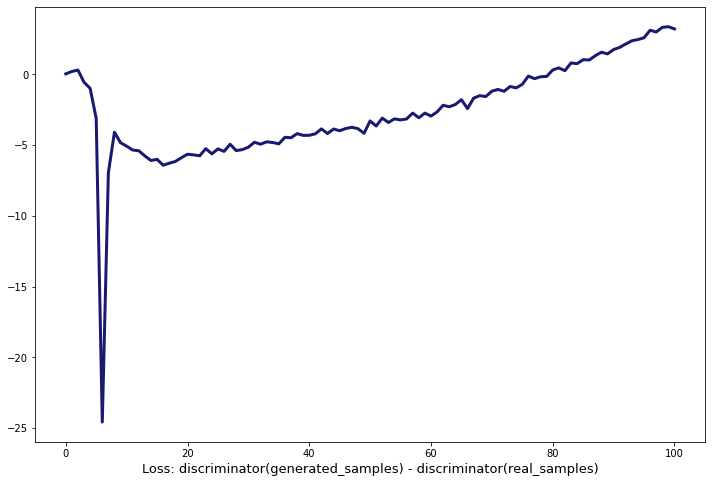

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(loss_list,color= 'midnightblue', linewidth =3)
plt.xlabel('training step',fontsize=14)
plt.xlabel('Loss: discriminator(generated_samples) - discriminator(real_samples)'
,fontsize=13)
# plt.title('GAN Training Loss (running avg.)', fontsize = 16)
plt.show();

In [ ]:
# save trained generator
torch.save(averaged_generator.state_dict(), '/content/drive/MyDrive/torchsde/train_on_S&P/gan_generator_model')



In [ ]:
#Later to restore:
is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'
if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")
# Data
ts, data_size, train_dataloader = get_historical_data(batch_size=batch_size, device=device)
infinite_train_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it)
generator = Generator(data_size, initial_noise_size, noise_size, hidden_size, mlp_size, num_layers).to(device)
averaged_generator = swa_utils.AveragedModel(generator)
averaged_generator.load_state_dict(torch.load('/content/drive/MyDrive/torchsde/train_on_S&P/gan_generator_model'))
averaged_generator.eval()

AveragedModel(
  (module): Generator(
    (_initial): MLP(
      (_model): Sequential(
        (0): Linear(in_features=5, out_features=16, bias=True)
        (1): LipSwish()
        (2): Linear(in_features=16, out_features=16, bias=True)
        (3): LipSwish()
        (4): Linear(in_features=16, out_features=16, bias=True)
      )
    )
    (_func): GeneratorFunc(
      (_drift): MLP(
        (_model): Sequential(
          (0): Linear(in_features=17, out_features=16, bias=True)
          (1): LipSwish()
          (2): Linear(in_features=16, out_features=16, bias=True)
          (3): LipSwish()
          (4): Linear(in_features=16, out_features=16, bias=True)
          (5): Tanh()
        )
      )
      (_diffusion): MLP(
        (_model): Sequential(
          (0): Linear(in_features=17, out_features=16, bias=True)
          (1): LipSwish()
          (2): Linear(in_features=16, out_features=16, bias=True)
          (3): LipSwish()
          (4): Linear(in_features=16, out_features=4

In [ ]:
with open('SP_all_daily_30day_stock_array.pkl', 'rb') as f:
  stock_array = pickle.load(f)
stock_array = stock_array.astype(np.float32)
return_array = np.zeros((stock_array.shape[0],stock_array.shape[1]-1))
for row in range(return_array.shape[0]):
  return_array[row,:] = np.diff(np.log(stock_array[row,:]))

return_array = return_array.astype(np.float32)

In [ ]:
idx = np.random.randint(stock_array.shape[0], size =500)

real_samples = return_array[idx,:]


t_size = stock_array.shape[1]

ts = torch.linspace(0, t_size - 1, t_size, device=device)

with torch.no_grad():
    # generated_samples = generator(ts, return_array.shape[0]).cpu()
    generated_samples = averaged_generator(ts, 100000).cpu()
generated_samples = torchcde.LinearInterpolation(generated_samples).evaluate(ts)
generated_samples = generated_samples[..., 1]



In [ ]:
generated_samples_np = generated_samples.cpu().detach().numpy()
generated_samples_np.shape

(100000, 30)

In [ ]:
# Plot some sample paths
num_paths = 1000
real_samples = return_array[np.random.randint(return_array.shape[0], size=num_paths), :]
real_samples = np.append(np.zeros((real_samples.shape[0],1)), real_samples, axis=1)
synth_samples = generated_samples_np[np.random.randint(generated_samples_np.shape[0], size=num_paths), :]

In [ ]:
real_samples.shape, synth_samples.shape

((1000, 30), (1000, 30))

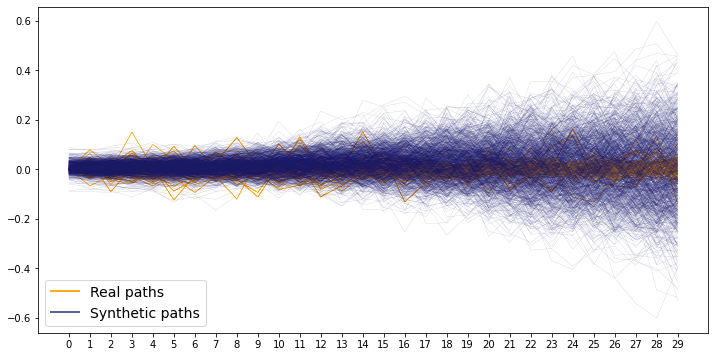

In [ ]:
# Plot samples
xs = np.arange(real_samples.shape[1])
plt.figure(figsize=(12,6))
for row in range(real_samples.shape[0]):
    plt.plot(xs, real_samples[row,:], color='orange', linewidth=0.2, alpha=0.9, label = 'Real paths')

for row in range(synth_samples.shape[0]):
    plt.plot(xs, synth_samples[row,:]/50, color='midnightblue', linewidth=0.1, alpha=0.7, label = 'Synthetic paths')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
leg = plt.legend(by_label.values(), by_label.keys(), fontsize = 14, loc = 'lower left')
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)
#plt.title(" Sample real paths vs. synthetic paths (log-return)", fontsize = 16)
plt.xticks(np.arange(min(xs), max(xs)+1, 1.0))
plt.show()


In [ ]:
# with open('generated_SP_log_return_paths_100k.pickle', 'wb') as handle:
#     pickle.dump(generated_samples, handle)
